In [1]:
!pip install PyYAML --upgrade
!pip install labelme
!pip install shapely
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 636 kB 8.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.5 MB 7.6 MB/s 
     |████████████████████████████████| 7.7 MB 23.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 68.3 MB 58 kB/s 
     |████████████████████████████████| 317 kB 71.4 MB/s 
  Created wheel for labelme: filename=labelme-4.5.9-py3-none-any.whl size=1465486 sha256=7387203ae16262fc9399591a86755841509ca55ca0977ed36ac11c93346065dd
  Stored in directory: /root/.cache/pip/wheels/1a/69/e0/8e8530643e291ff5b3eeb05568d873ad42b08c15166885a288
  Created wheel for imgviz: filename=imgviz-1.2.6-py3-none-any.whl size=7674115 sha256=e0bc86429d1af601c5fde570b4dd98276f68c12c0a5275dac90decd97c2c518d
  Stored in directory: /r

In [4]:
!wget https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar -xzf /content/ShelfImages.tar.gz
!rm /content/ShelfImages.tar.gz
!wget https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv

--2021-08-15 15:20:24--  https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517978 (506K) [text/plain]
Saving to: ‘annotations.csv’

annotations.csv     100%[===================>] 505.84K  --.-KB/s    in 0.03s   

2021-08-15 15:20:24 (18.8 MB/s) - ‘annotations.csv’ saved [517978/517978]



In [9]:
import numpy as np
import json
import pandas as pd
import cv2
import pandas as pd
import os


test = os.listdir("/content/ShelfImages/test")
train = os.listdir("/content/ShelfImages/train")

df = pd.read_csv('/content/annotations.csv',names=["filename","xmin","ymin","xmax","ymax","class"]) 

df['class'] = 1

train_anno=df[df['filename'].isin(train)]
test_anno=df[df['filename'].isin(test)]

di = {"instances_train.json":train_anno,"instances_test.json":test_anno}

for i in ["instances_train.json","instances_test.json"]:
  save_json_path = i #output path to the json
  data = di[i]
  images = []
  categories = []
  annotations = []

  category = {}
  category["supercategory"] = 'none'
  category["id"] = 0
  category["name"] = 'None'
  categories.append(category)

  data['fileid'] = data['filename'].astype('category').cat.codes
  data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
  data['categoryid'] = data['categoryid']+1
  data['annid'] = data.index

  def image(row):
    image = {}
    im = cv2.imread("ShelfImages/"+i[i.index("_")+1:i.index(".")]+"/"+row.filename)
    image["height"] = im.shape[0]
    image["width"] = im.shape[1]
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

  def category(row):
    category = {}
    category["supercategory"] = 'Product'
    category["id"] = row.categoryid
    category["name"] = 'Product'
    return category

  def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

  for row in data.itertuples():
    annotations.append(annotation(row))

  imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
  for row in imagedf.itertuples():
    images.append(image(row))

  catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
  for row in catdf.itertuples():
    categories.append(category(row))

  data_coco = {}
  data_coco["images"] = images
  data_coco["categories"] = categories
  data_coco["annotations"] = annotations
  json.dump(data_coco, open(save_json_path, "w"), indent=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Pandas(Index=0, filename='C1_P01_N1_S2_1.JPG', xmin=1008, ymin=1552, xmax=1260, ymax=1928, _6=1, fileid=0, categoryid=1, annid=0)
Pandas(Index=238, filename='C1_P02_N1_S5_1.JPG', xmin=1032, ymin=2080, xmax=1204, ymax=2408, _6=1, fileid=0, categoryid=1, annid=238)


In [10]:
import random
import cv2
import os 
import numpy as np
import pandas as pd  
import copy
import torch
import base64   
import json
import math
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import files

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import ColorMode
from detectron2.engine.defaults import DefaultPredictor
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

In [11]:
## Registering data in COCO format
for d in ["train","test"]:
    register_coco_instances(f"grocery_{d}", {}, f"/content/instances_{d}.json", f"/content/ShelfImages/{d}/")

In [12]:
## Loading the data

dataset_dicts = DatasetCatalog.get("grocery_train")
grocery_metadata = MetadataCatalog.get("grocery_train")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [13]:

## Making a Cutsom Mapper to perform augmentations

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((800,800)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomApply(T.RandomRotation(angle=[-30,30], expand=True, center=None, sample_style="range", interp=None), prob=0.25),
                      T.RandomApply(T.RandomCrop(crop_type="relative_range", crop_size=(0.4, 0.4)), 
                      prob=0.20)
                      ]
   
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

## Class which can call the custom mapper we made

class GroceryTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [14]:
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=grocery_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (18, 18))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.RETINANET.NUM_CLASSES = 2

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [50]:
cfg.DATASETS.TRAIN = ("grocery_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = GroceryTrainer(cfg) 
trainer.resume_or_load(resume=True)

[08/15 16:22:11 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [51]:
trainer.train()

[08/15 16:22:15 d2.engine.train_loop]: Starting training from iteration 5000


/usr/local/lib/python3.7/dist-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))
/usr/local/lib/python3.7/dist-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be

[08/15 16:22:27 d2.utils.events]:  eta: 0:45:32  iter: 5019  total_loss: 0.3092  loss_cls: 0.06067  loss_box_reg: 0.2454  time: 0.5589  data_time: 0.2281  lr: 0.00025  max_mem: 4953M
[08/15 16:22:38 d2.utils.events]:  eta: 0:44:42  iter: 5039  total_loss: 0.1458  loss_cls: 0.03109  loss_box_reg: 0.1192  time: 0.5530  data_time: 0.1336  lr: 0.00025  max_mem: 4953M
[08/15 16:22:49 d2.utils.events]:  eta: 0:45:09  iter: 5059  total_loss: 0.1841  loss_cls: 0.03199  loss_box_reg: 0.1495  time: 0.5583  data_time: 0.1588  lr: 0.00025  max_mem: 4953M
[08/15 16:23:01 d2.utils.events]:  eta: 0:45:47  iter: 5079  total_loss: 0.2048  loss_cls: 0.04722  loss_box_reg: 0.1547  time: 0.5616  data_time: 0.1242  lr: 0.00025  max_mem: 4953M
[08/15 16:23:13 d2.utils.events]:  eta: 0:45:50  iter: 5099  total_loss: 0.2208  loss_cls: 0.05649  loss_box_reg: 0.1582  time: 0.5669  data_time: 0.1939  lr: 0.00025  max_mem: 4953M
[08/15 16:23:24 d2.utils.events]:  eta: 0:46:19  iter: 5119  total_loss: 0.1732  loss

In [52]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

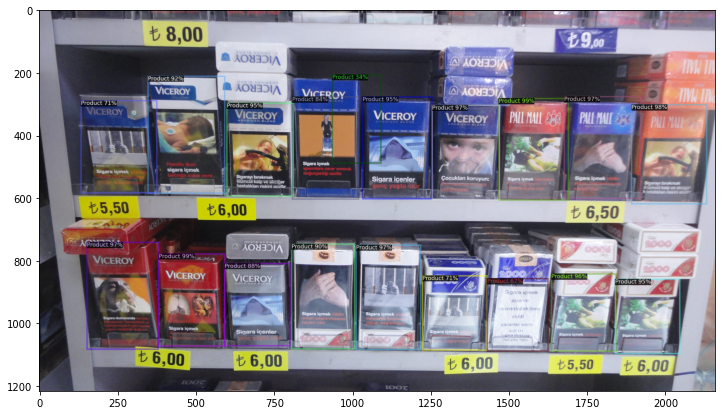

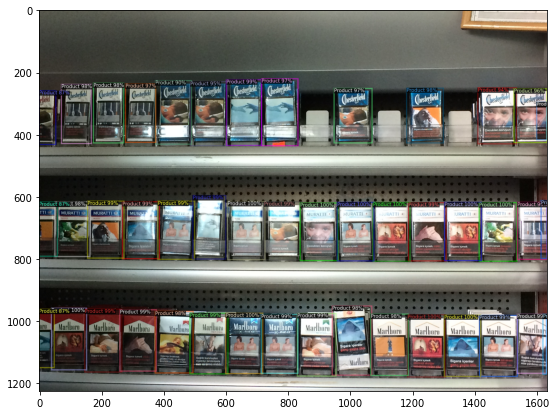

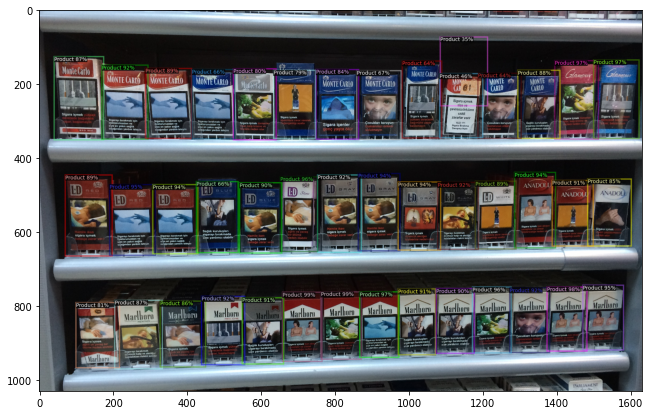

In [53]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=grocery_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

In [54]:
from detectron2.evaluation import (
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)

In [55]:
output_folder="output/"        
output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
evaluator_list = []
evaluator_type = MetadataCatalog.get("grocery_test").evaluator_type
evaluator_list.append(COCOEvaluator("grocery_test", cfg, True, output_folder))

WARNING [08/15 17:11:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


In [56]:
eval = DatasetEvaluators(evaluator_list)

In [57]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import inference_on_dataset
val_loader = build_detection_test_loader(cfg, "grocery_test")
print(inference_on_dataset(trainer.model, val_loader, eval))

WARNING [08/15 17:11:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/15 17:11:22 d2.data.datasets.coco]: Loaded 71 images in COCO format from /content/instances_test.json
[08/15 17:11:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/15 17:11:22 d2.data.common]: Serializing 71 elements to byte tensors and concatenating them all ...
[08/15 17:11:22 d2.data.common]: Serialized dataset takes 0.10 MiB
[08/15 17:11:22 d2.evaluation.evaluator]: Start inference on 71 batches
[08/15 17:11:26 d2.evaluation.evaluator]: Inference done 11/71. Dataloading: 0.1435 s/iter. Inference: 0.1044 s/iter. Eval: 0.0023 s/iter. Total: 0.2502 s/iter. ETA=0:00:15
[08/15 17:11:31 d2.evaluation.evaluator]: Inference done 30/71. Dataloading: 0.1618 s/iter. Inference: 0.0990 s/iter. Eval: 0.0011 s/iter. Total: 0.2627 s/iter. 

In [58]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [59]:
!mv /content/output/model_final.pth /content/drive/MyDrive/